In [13]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rois = [
    "V1",
    "V2",
    "V3",
    "V3b",
    "hV4",
    "LO1",
    "LO2",
    "VO1",
    "VO2",
    "V3a",
    "hMT",
    "MST",
    "SPL1",
    "IPS_anterior",
    "IPS_posterior"
    ]

roi_groups = {
    0 : ["V1","V2","V3"],
    1 : ["V3b","hV4","LO1","LO2","VO1","VO2"],
    2 : ["V3a","hMT","MST"],
    3 : ["IPS\nanterior","IPS\nposterior","SPL1",]
}

significance_loc_dict = {
    'V1': {'fb':-.3,'lr':.1},
    'V2': {'fb':.7,'lr':1.1},
    'V3': {'fb':1.7,'lr':2.1},
    'V3b':{'fb':-.4,'lr':0},
    'hV4':{'fb':.6,'lr':1},
    'LO1':{'fb':1.6,'lr':2.},
    'LO2':{'fb':2.6,'lr':3},
    'VO1':{'fb':3.6,'lr':4},
    'VO2':{'fb':4.6,'lr':5},
    'V3a': {'fb':-.3,'lr':.1},
    'hMT': {'fb':.7,'lr':1.1},
    'MST': {'fb':1.7,'lr':2.1},
    'IPS\nanterior': {'fb':-.3,'lr':.1},
    'IPS\nposterior': {'fb':.7,'lr':1.1},
    'SPL1': {'fb':1.7,'lr':2.1},     
}

In [3]:
def p_mark(x):
    if x<.001:
        return "***"
    elif x<.01:
        return "**"
    elif x<.05:
        return "*"
    else:
        return ""

def read_data(
    motion_type: str,
    design: str,
    ):
    df_list = glob.glob(f'{Path.home()}/Projects/implied_motion_docs/src_implied_motion/data/decoding/{motion_type}/*{design}.csv')
    dfs = [pd.read_csv(x) for x in df_list]
    dfs = [x.reset_index(drop=True) for x in dfs]
    dfs = [x.replace({"roi":{'IPS_anterior':"IPS\nanterior",'IPS_posterior':'IPS\nposterior'}}) for x in dfs]
    significance_list =glob.glob(f'{Path.home()}/Projects/implied_motion_docs/src_implied_motion/data/permutation/*{motion_type}_{design}_max_statistics.csv')
    significance_dfs = [pd.read_csv(x) for x in significance_list]
    significance_df = pd.concat(significance_dfs)
    significance_df['p_mark'] = significance_df['p_values'].apply(p_mark)
    significance_df = significance_df.replace({"ROIs":{'IPS_anterior':"IPS\nanterior",'IPS_posterior':'IPS\nposterior'}})

    significance_threshold = [
        [
        significance_df[(significance_df.ROIs == "V1") & (significance_df.target_decode == "fb")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "LO1") & (significance_df.target_decode == "fb")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "MST") & (significance_df.target_decode == "fb")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "SPL1") & (significance_df.target_decode == "fb")]["permutation_chance"].reset_index(drop=True)[0] * 100
        ],
        [
        significance_df[(significance_df.ROIs == "V1") & (significance_df.target_decode == "lr")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "LO1") & (significance_df.target_decode == "lr")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "MST") & (significance_df.target_decode == "lr")]["permutation_chance"].reset_index(drop=True)[0] * 100,
        significance_df[(significance_df.ROIs == "SPL1") & (significance_df.target_decode == "lr")]["permutation_chance"].reset_index(drop=True)[0] * 100
        ]
    ]
    
    return dfs, significance_df, significance_threshold


In [11]:
def create_subtitle(fig, grid, title):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

def plot_results(
    roi_groups,
    dfs,
    significance_df,
    significance_threshold,
    motion_type,
    cmaps
    ):


    fig, axs = plt.subplots(2, 4,sharey=True)
    grid = plt.GridSpec(2, 4)
    create_subtitle(fig, grid[0, ::], 'Forward vs. Backward')
    create_subtitle(fig, grid[1, ::], 'Left vs. Right')
    y=70 if motion_type == 'cross' else 100
    for i, target_decode in enumerate(['fb','lr']):
        for j,roi_group in roi_groups.items():
            accuracy_df = []
            current_significance = significance_df[significance_df.ROIs.isin(roi_group) & (significance_df.target_decode == target_decode)][['ROIs','p_mark']].reset_index(drop=True)
            for row_no, row in current_significance.iterrows():
                axs[i,j].text(x=row_no,y=y,s=row['p_mark'],horizontalalignment='center',verticalalignment='center')
            for df in dfs:
                if (df.target == target_decode).all() and df.roi.isin(roi_group).all():
                    accuracy_df.append(df[df.type == 'real'])

            
            accuracy_df = pd.concat(accuracy_df)        
            accuracy_df['accuracy'] =  accuracy_df['accuracy'] * 100

            sns.stripplot(
                data=accuracy_df,
                x='roi',
                y='accuracy',
                dodge=True,
                color="k",
                alpha=.5,
                s=10,
                order=roi_groups[j],
                ax=axs[i,j])

            sns.barplot(
                data=accuracy_df,
                x='roi',
                y='accuracy',
                ax=axs[i,j],
                errcolor="k",
                color=cmaps[j],
                order=roi_group,
                alpha=.9
            )

            axs[i,j].axhline(y=significance_threshold[i][j], color="k", linestyle='--',linewidth=4)
            #axs[i,j].legend_.remove()
            axs[i,j].set_xlabel("")

            if j == 0:
                axs[i,j].set_ylabel("% Accuracy")
            else:
                axs[i,j].set_ylabel("")


    plt.tight_layout()
    return fig

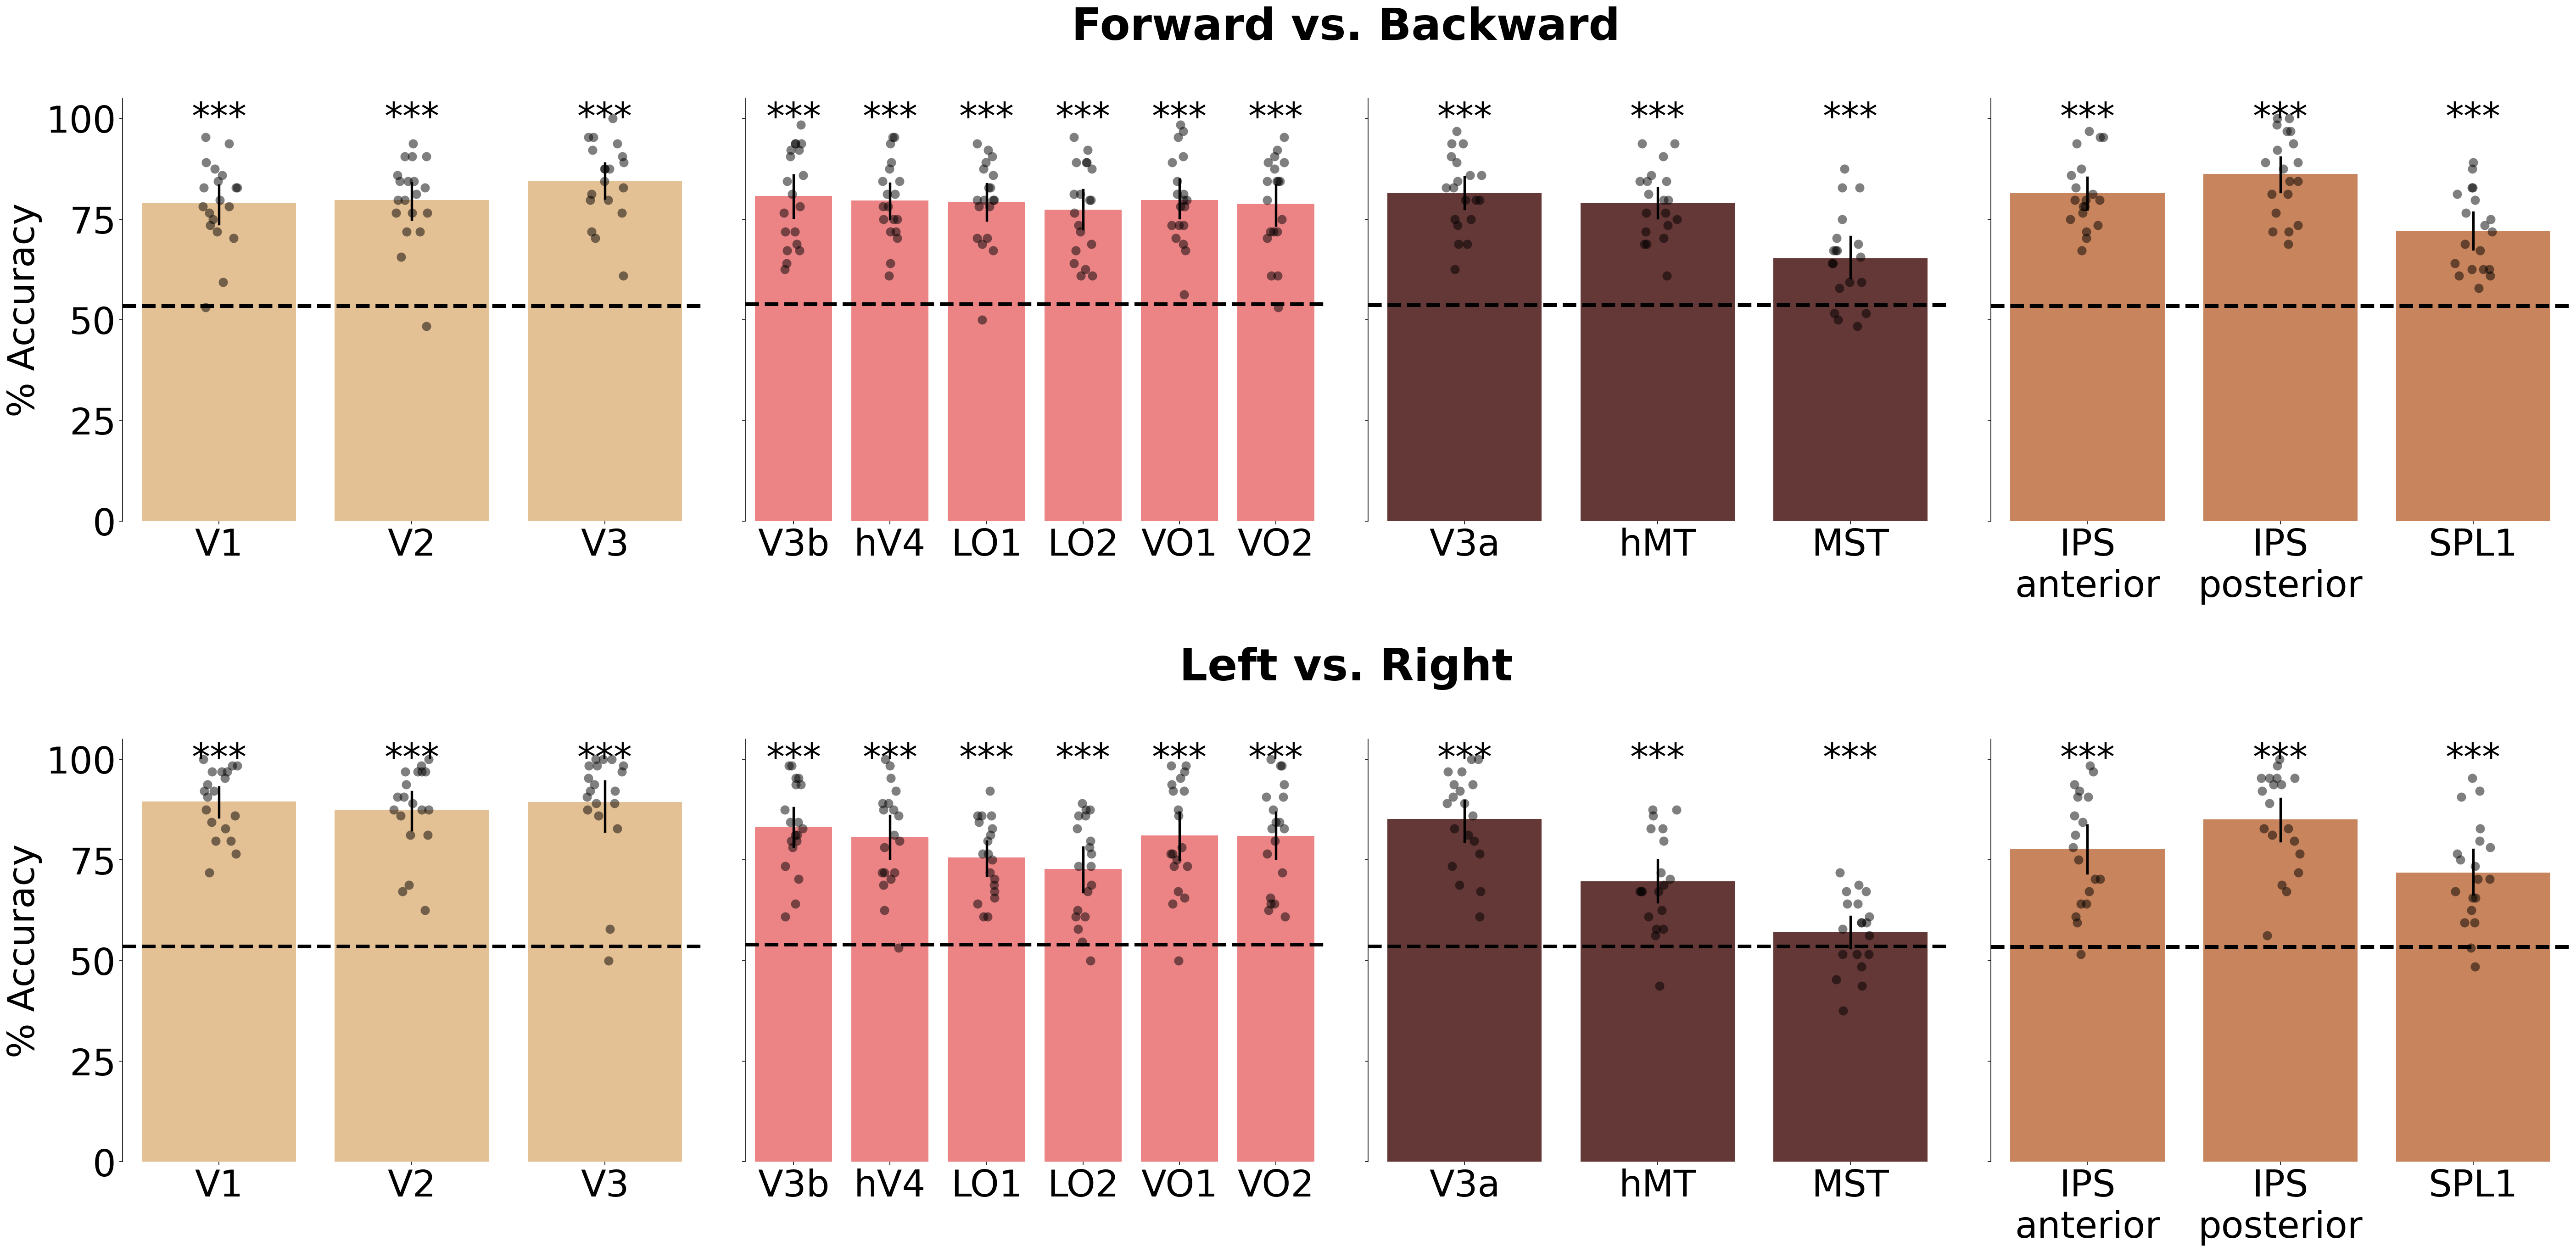

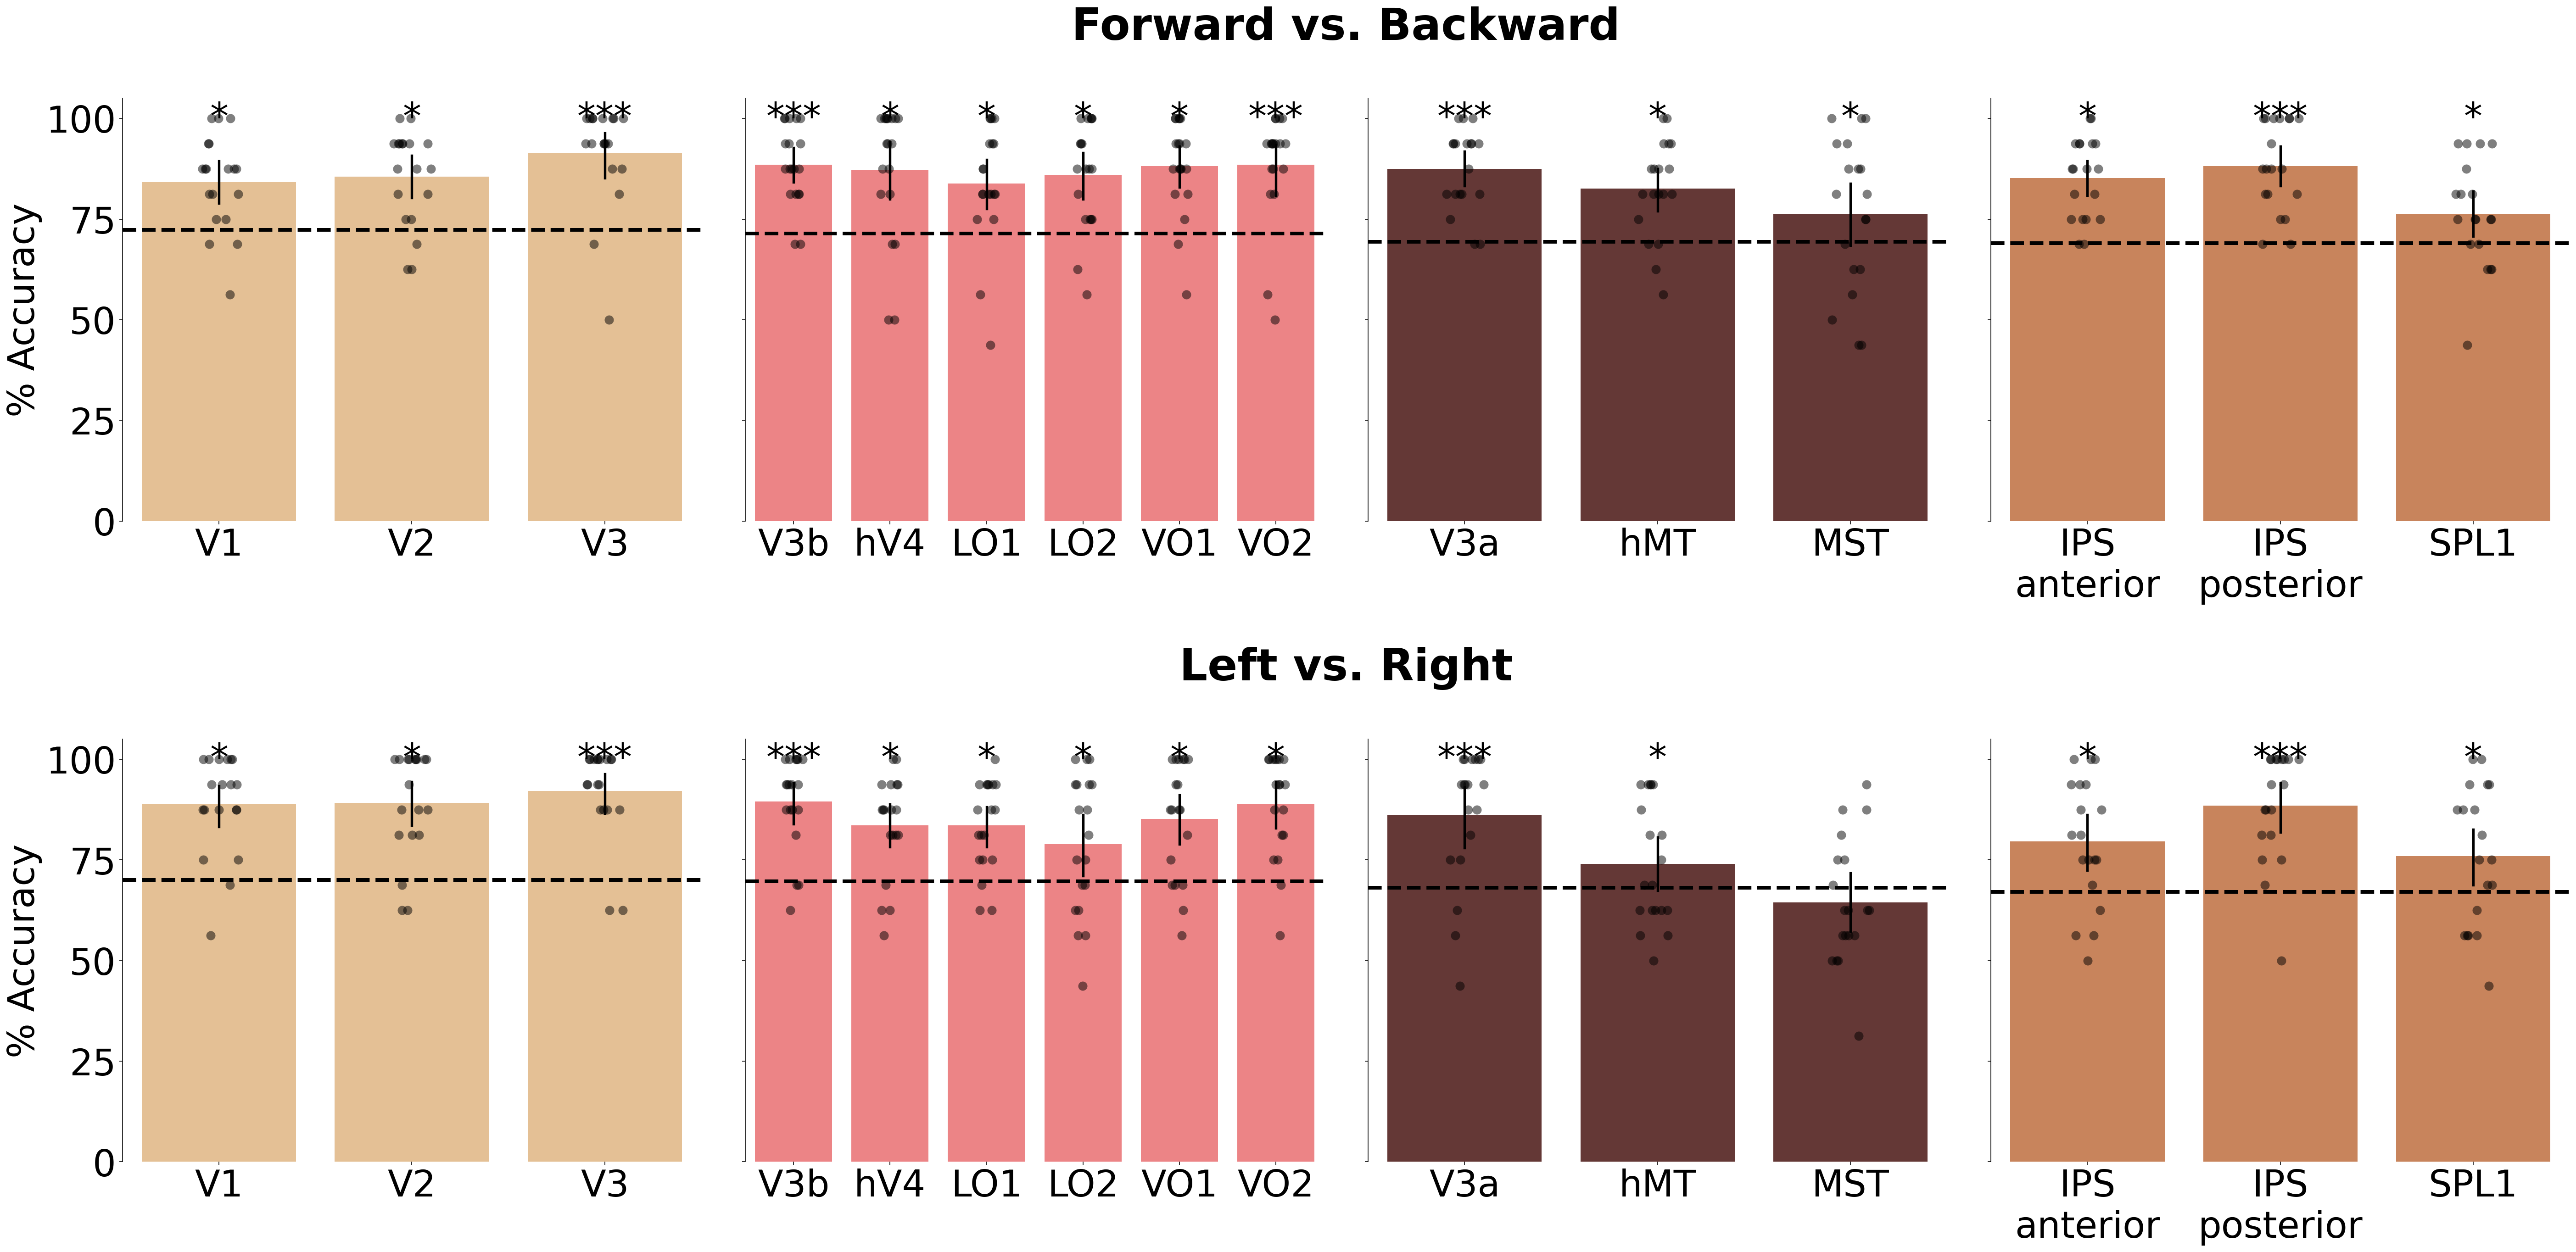

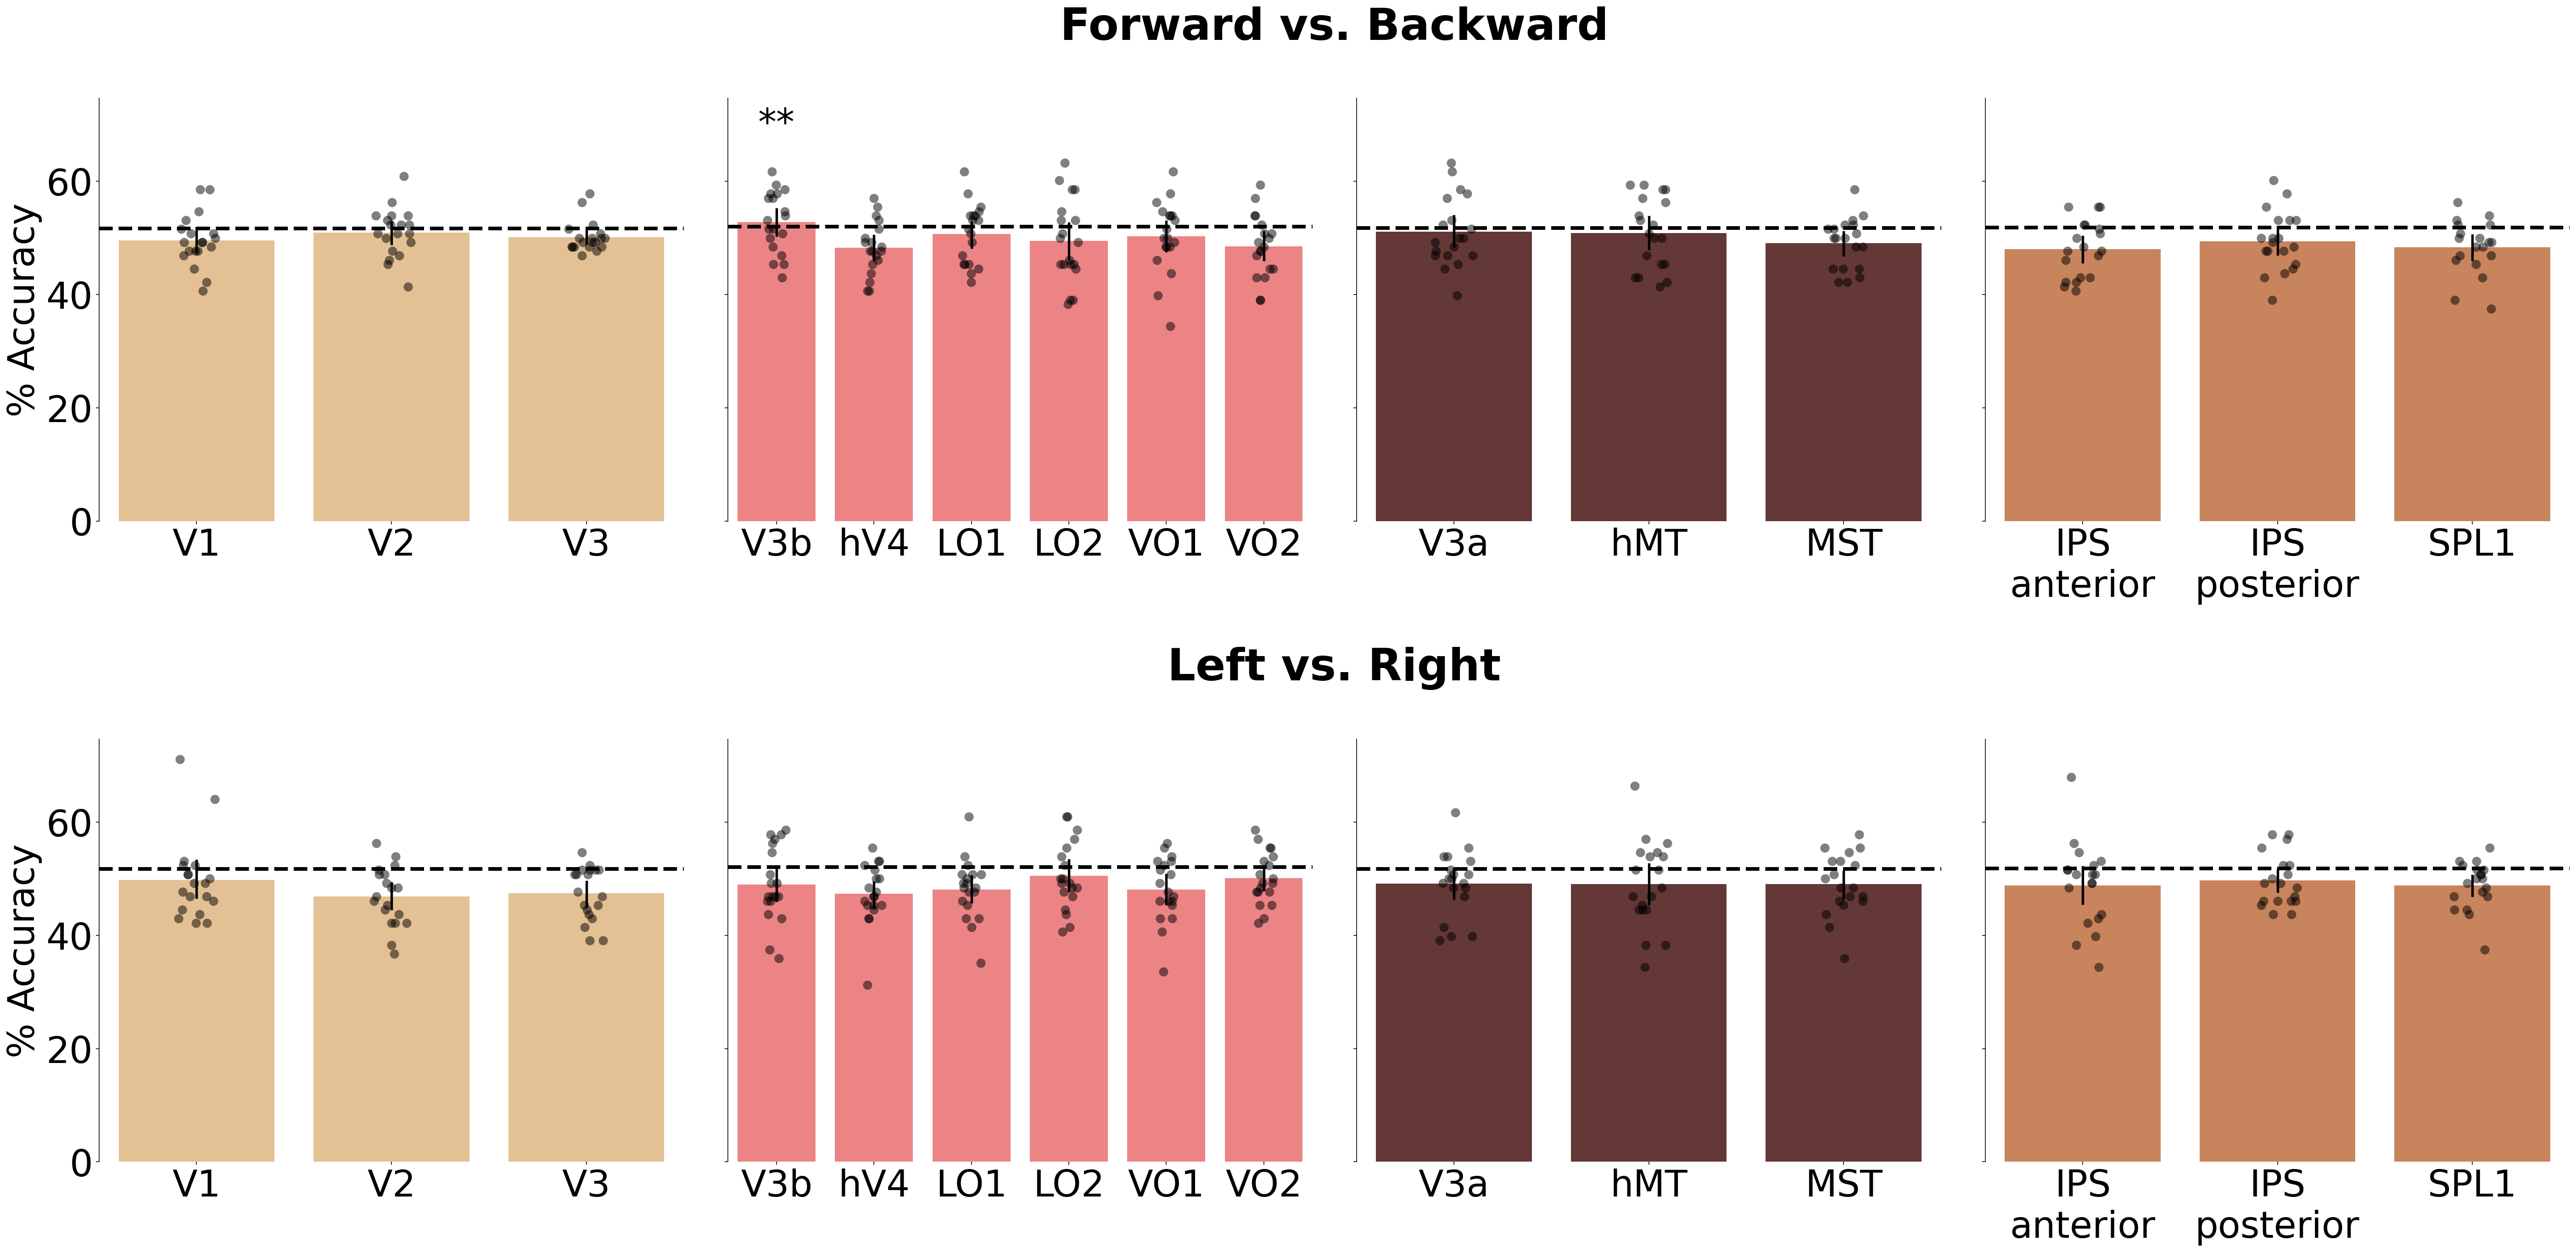

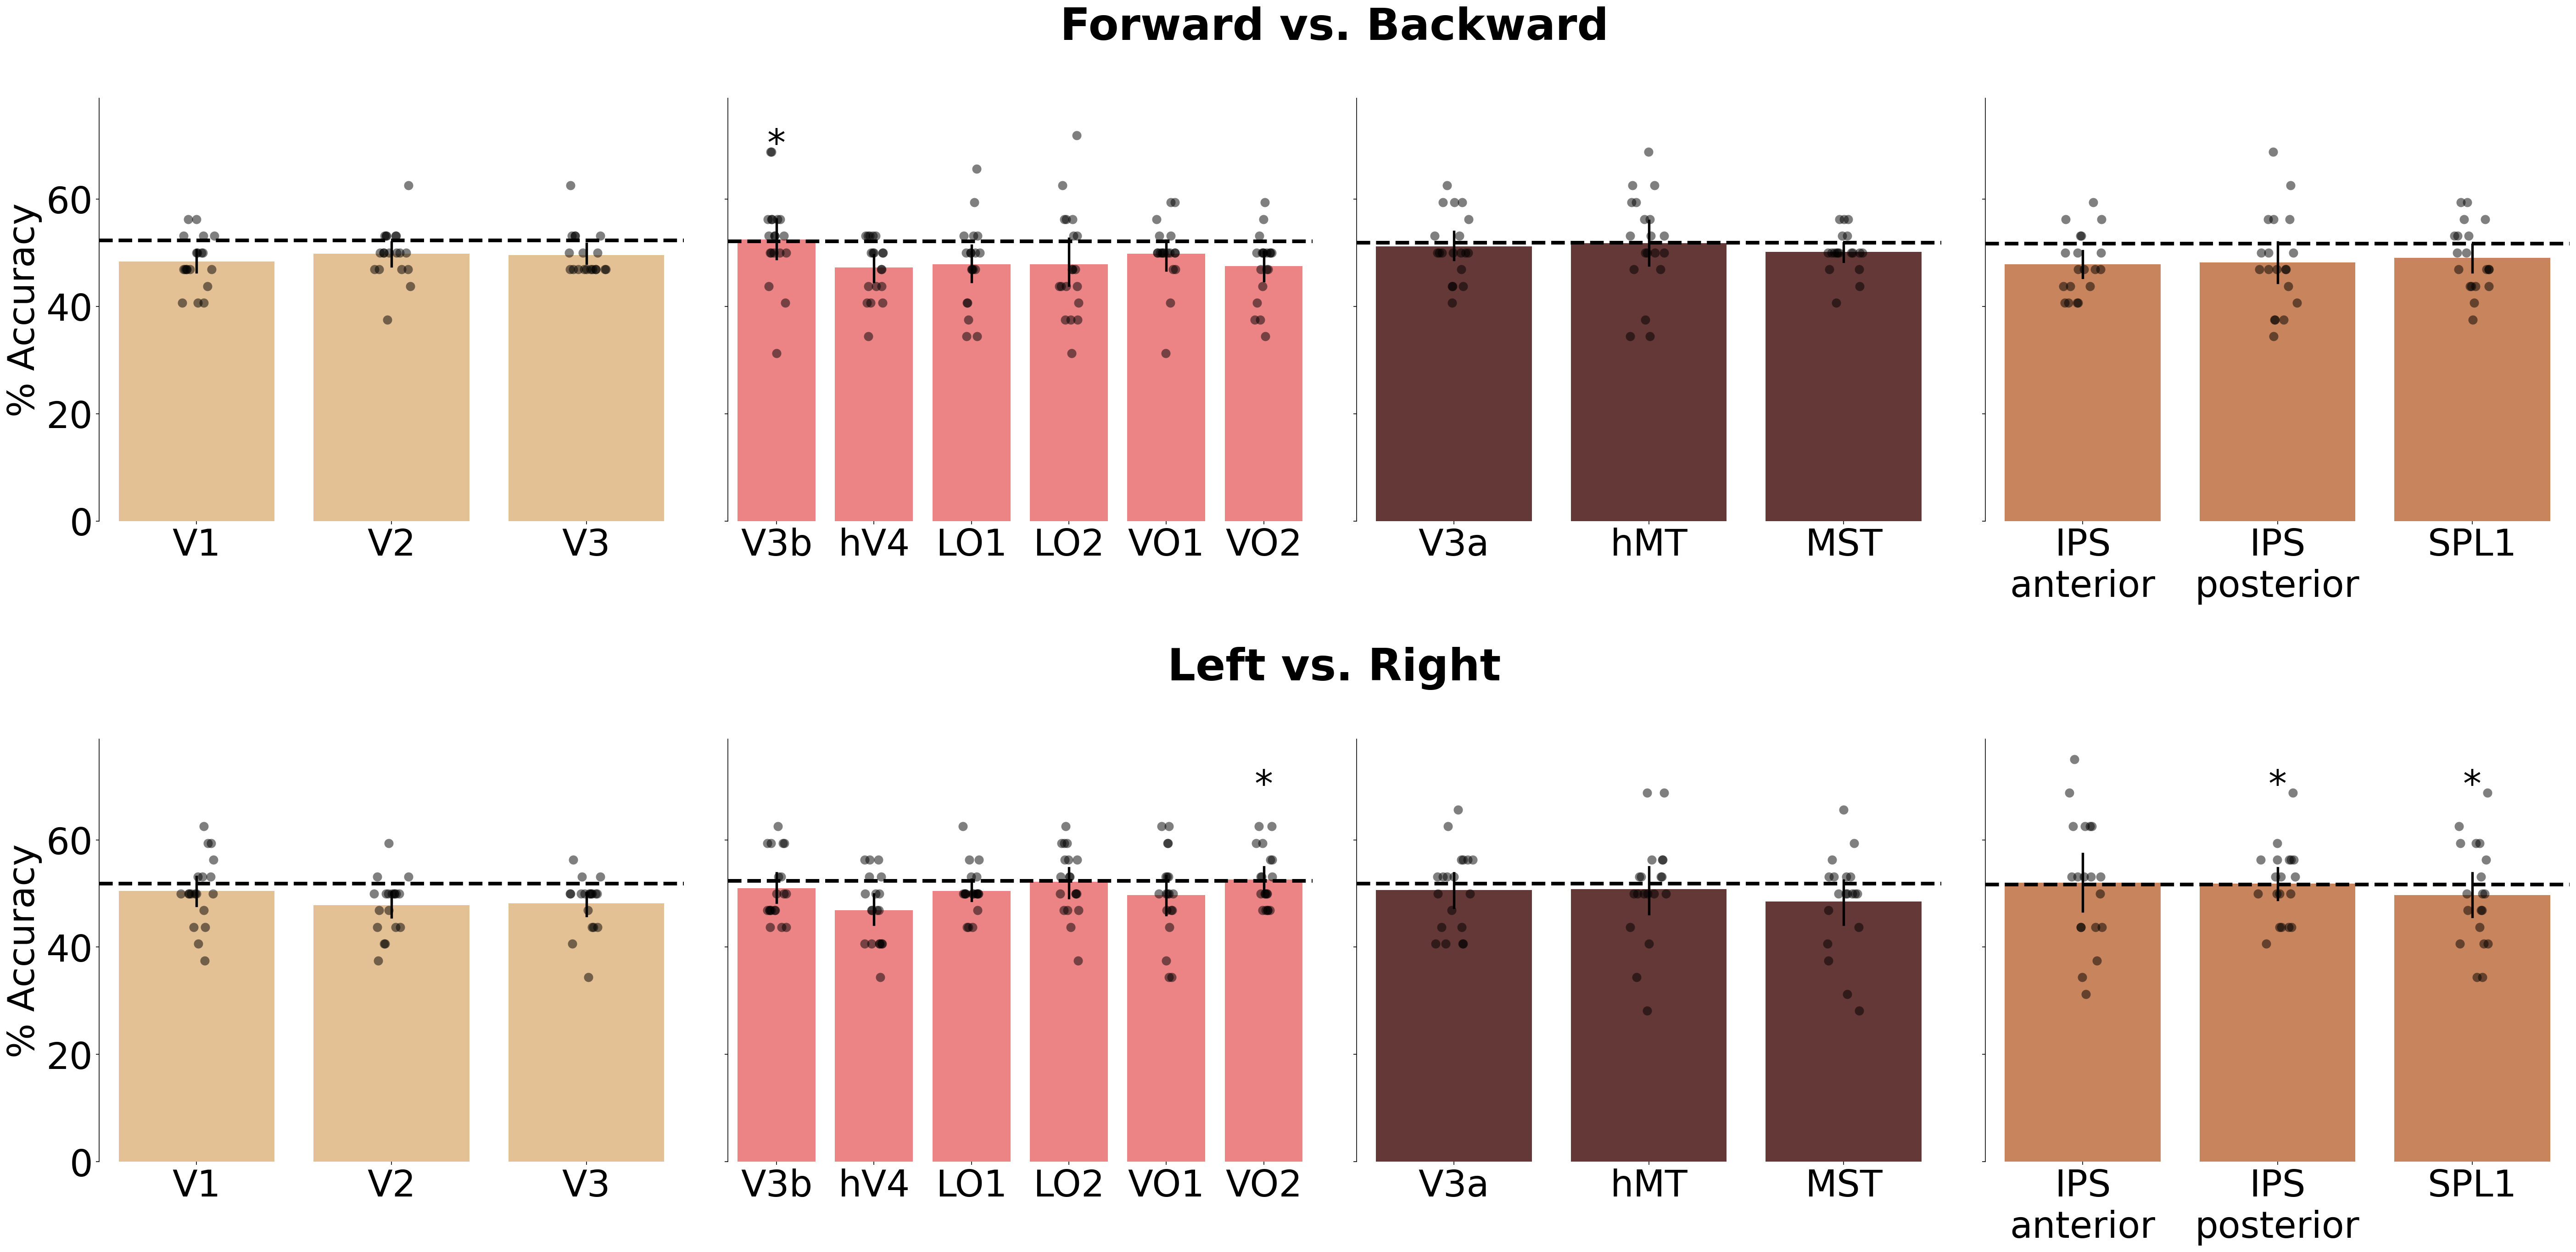

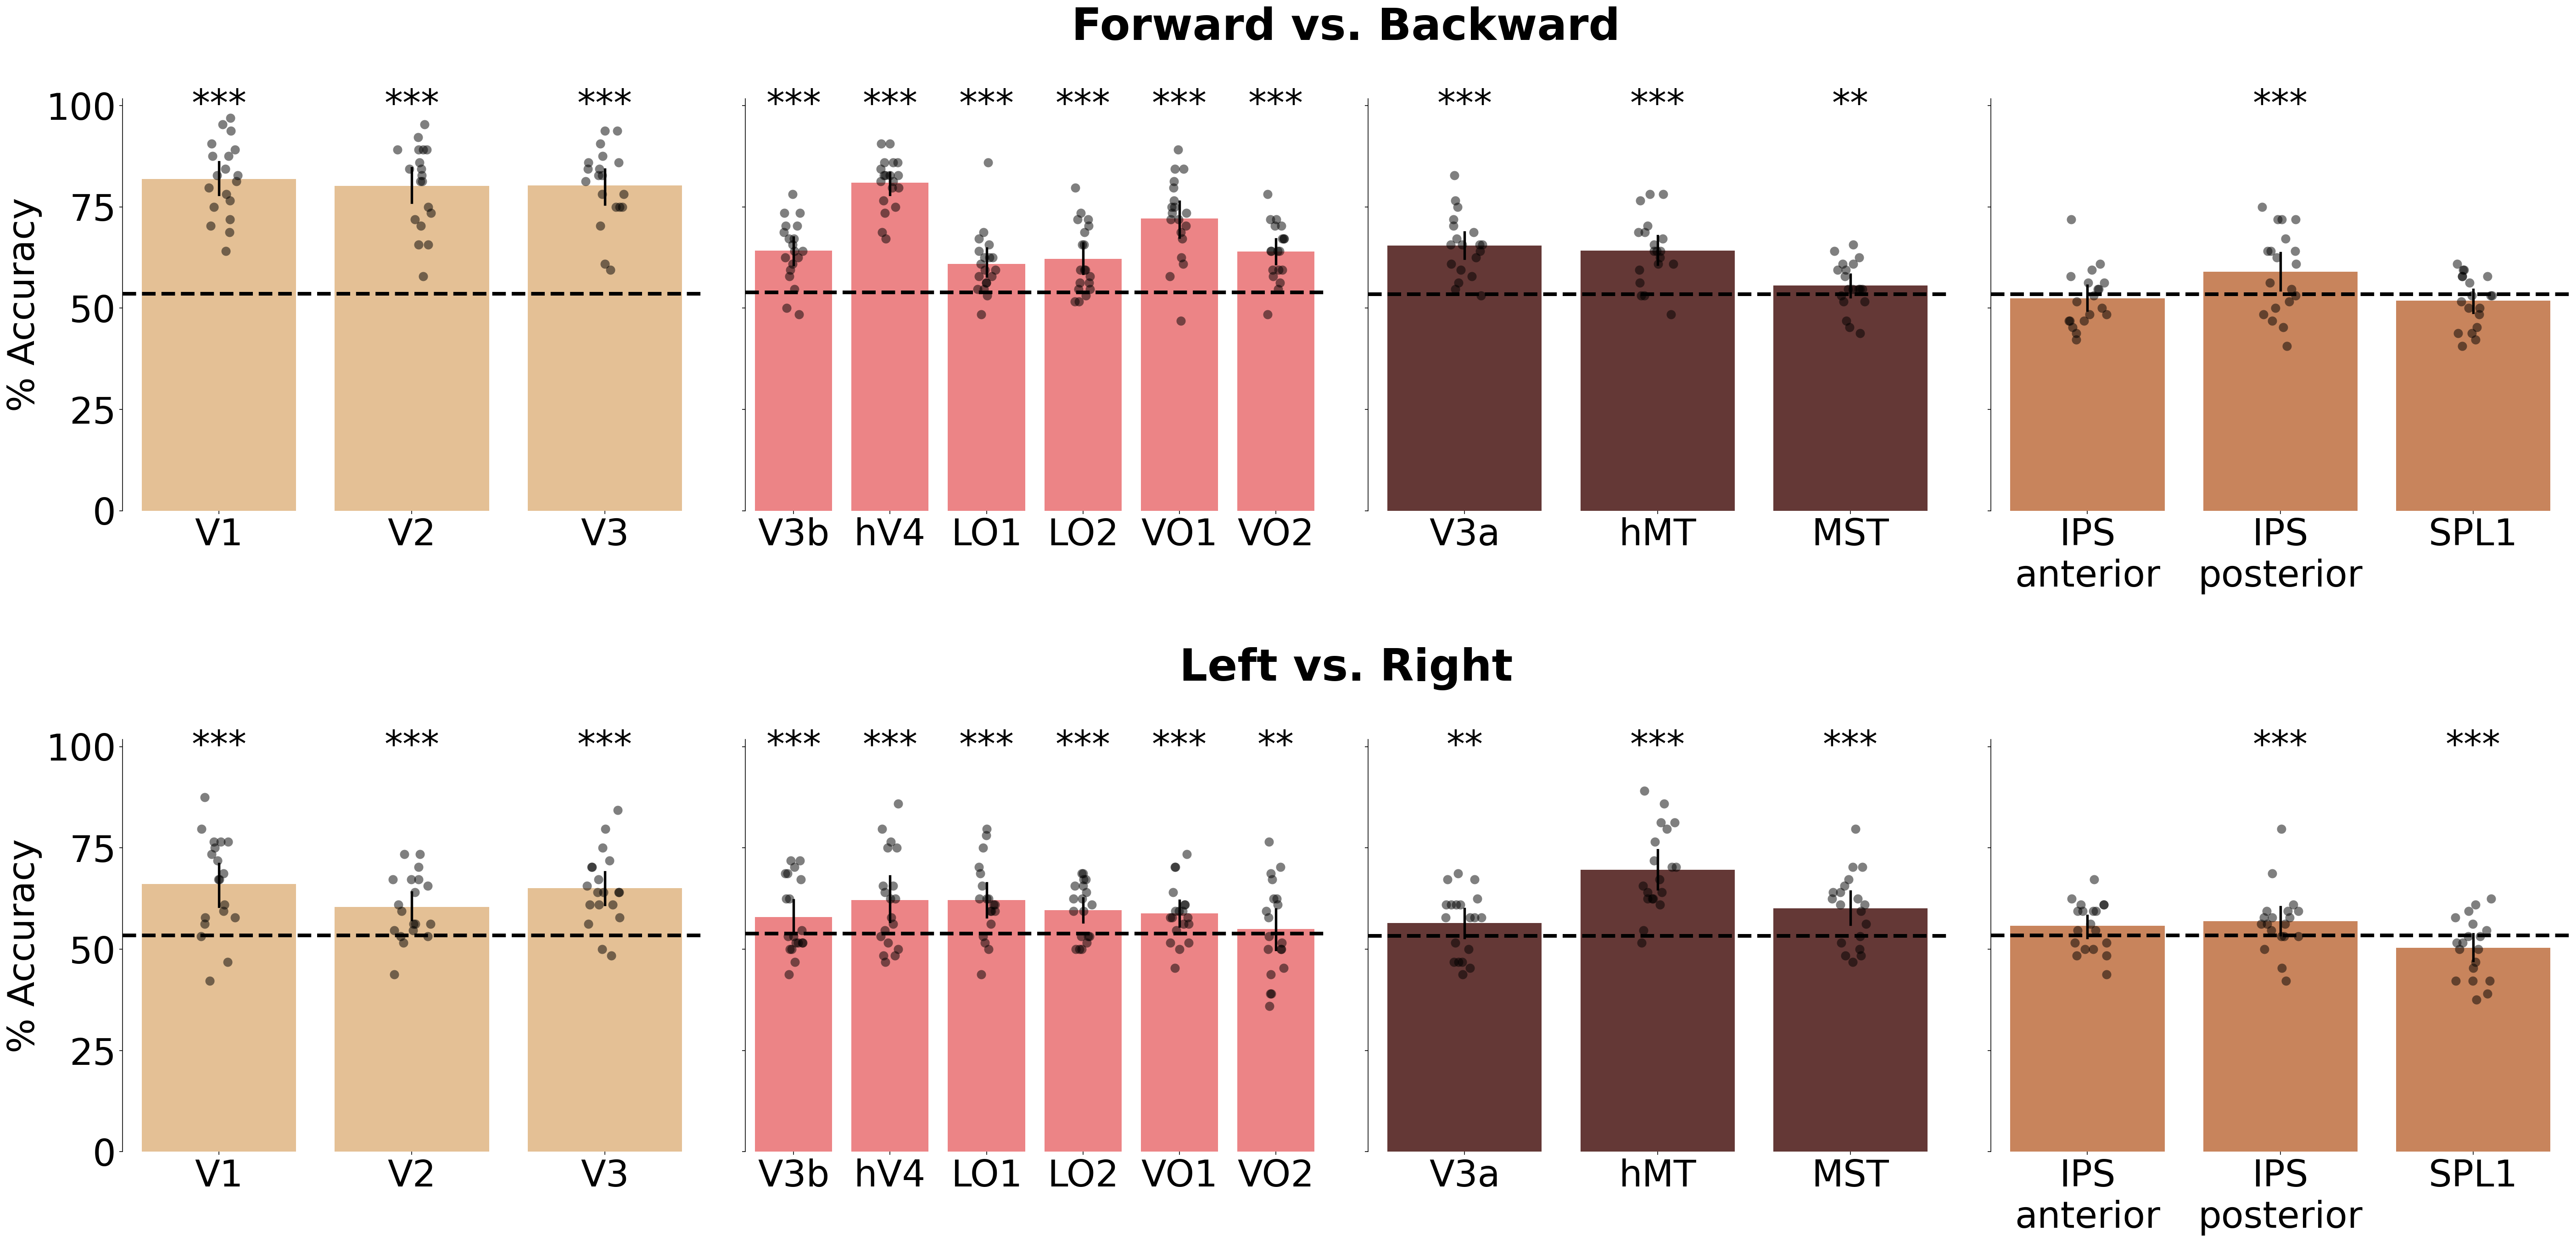

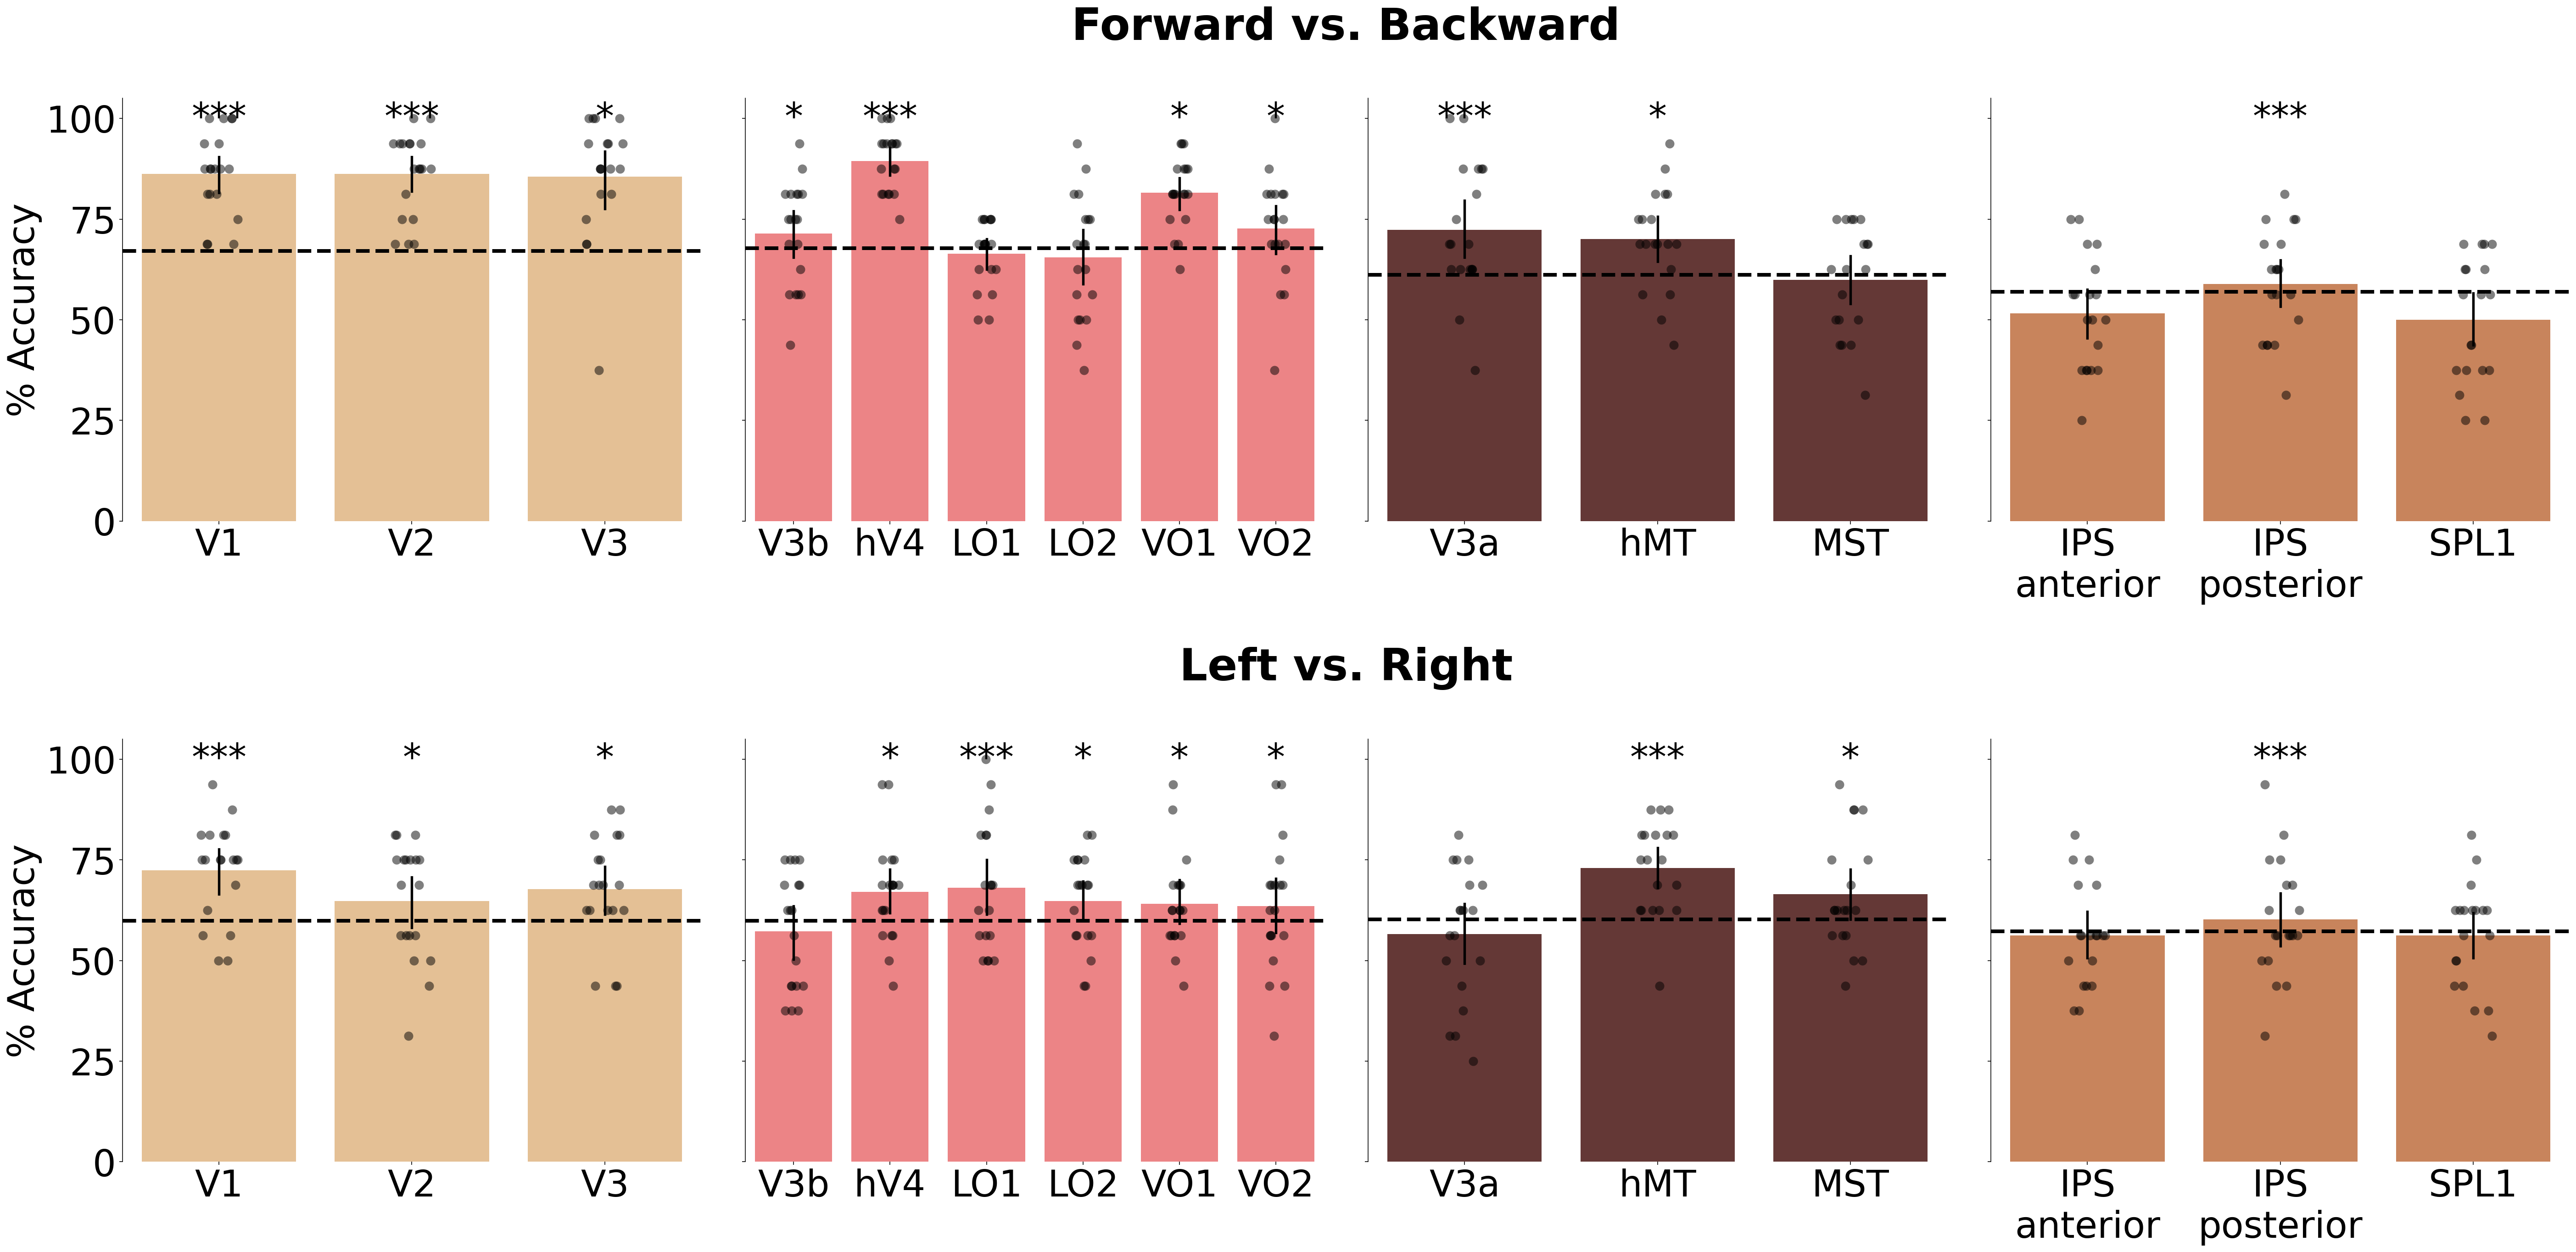

In [14]:
for motion_type in ['real','cross','implied']:
    for design_type in ['expanded','compact']:

        mpl.rcParams['axes.spines.right'] = False
        mpl.rcParams['axes.spines.top'] = False
        mpl.rcParams['axes.spines.bottom'] = False
        mpl.rcParams.update({'font.size': 40})
        plt.rcParams["figure.figsize"] = (40,40/2)

        cmaps = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236"]

        %config InlineBackend.figure_format = 'retina'
        
        dfs, significance_df, significance_threshold = read_data(motion_type,design_type)
        fig = plot_results(
            roi_groups,
            dfs,
            significance_df,
            significance_threshold,
            motion_type,
            cmaps
            )

        fig.savefig(f'{Path.home()}/Projects/implied_motion_docs/imgs/{motion_type}_{design_type}_plot.svg',transparent=True)